In [1]:
import os
impor

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder

In [2]:
# read the data sets
df = pd.read_csv('../data/clean_HR_Analytics.csv')

#### Split

In [3]:
# vertical split
target = "Attrition"
X = df.drop(columns=target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Build

In [4]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    RandomForestClassifier(random_state=42)
)

In [5]:
params = {
    "randomforestclassifier__n_estimators": range(50, 110, 5),
    "randomforestclassifier__max_depth": range(10, 50, 5)
}

In [6]:
model = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(50, 110, 5)},
             verbose=1)

In [7]:
# Train model
model.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 5),
                         'randomforestclassifier__n_estimators': range(50, 110, 5)},
             verbose=1)

In [8]:
cv_result = pd.DataFrame(model.cv_results_)
cv_result.head(6)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.514076      0.067212         0.070685        0.022708   
1       0.551339      0.042182         0.068061        0.012751   
2       0.678263      0.085703         0.061348        0.015928   
3       0.545731      0.051863         0.066744        0.017753   
4       0.603012      0.105094         0.058141        0.007724   
5       0.575059      0.077134         0.055770        0.002251   

  param_randomforestclassifier__max_depth  \
0                                      10   
1                                      10   
2                                      10   
3                                      10   
4                                      10   
5                                      10   

  param_randomforestclassifier__n_estimators  \
0                                         50   
1                                         55   
2                                         60   
3                                         65   
4                                         70   
5                                         75   

                                              params  split0_test_score  \
0  {'randomforestclassifier__max_depth': 10, 'ran...           0.855932   
1  {'randomforestclassifier__max_depth': 10, 'ran...           0.855932   
2  {'randomforestclassifier__max_depth': 10, 'ran...           0.855932   
3  {'randomforestclassifier__max_depth': 10, 'ran...           0.855932   
4  {'randomforestclassifier__max_depth': 10, 'ran...           0.855932   
5  {'randomforestclassifier__max_depth': 10, 'ran...           0.855932   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.863830           0.846809           0.855319           0.863830   
1           0.868085           0.846809           0.859574           0.863830   
2           0.863830           0.846809           0.855319           0.863830   
3           0.868085           0.846809           0.851064           0.859574   
4           0.872340           0.842553           0.846809           0.863830   
5           0.872340           0.846809           0.846809           0.863830   

   mean_test_score  std_test_score  rank_test_score  
0         0.857144        0.006341               77  
1         0.858846        0.007268               17  
2         0.857144        0.006341               77  
3         0.856293        0.007311               87  
4         0.856293        0.010892               87  
5         0.857144        0.009907               77

In [9]:
# Extract the best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__n_estimators': 95}

#### Evaluate

In [16]:
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print("Training Accuracy: ", round(train_acc, 2))
print("Test Accuracy: ", round(test_acc, 2))

Training Accuracy:  1.0
Test Accuracy:  0.87


##### Plot Confusion Matrix

In [10]:
# generate the confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[250,   5],
       [ 34,   5]])

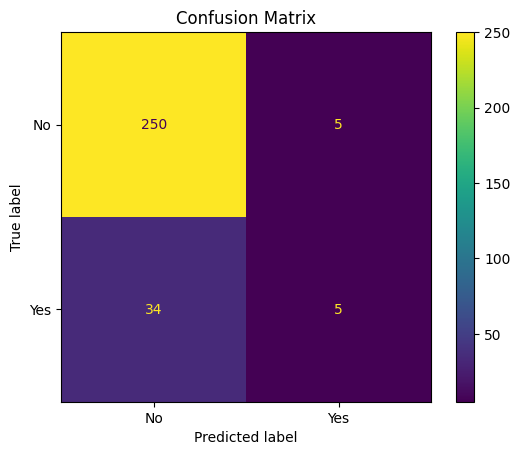

In [11]:
# Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# plot the confusion matrix
cm_display.plot() 
plt.title("Confusion Matrix");
plt.savefig('../reports/confusion_matrix_RF.jpg')

#### Communicate

In [18]:
# get feature names
features = model.best_estimator_.named_steps["onehotencoder"].get_feature_names_out()
# Extract the importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# create a series
features_imp = pd.Series(importances, index=features).sort_values()

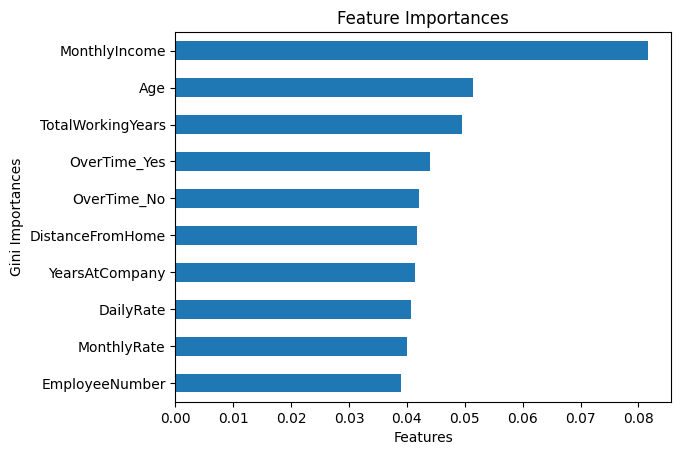

In [62]:
features_imp.tail(10).plot(kind="barh")
plt.xlabel("Features")
plt.ylabel("Gini Importances")
plt.title("Feature Importances");

#### Save the Model

In [11]:
import joblib
timestamp = pd.Timestamp.now().replace(microsecond=0).isoformat()
file_path = os.path.join('../models', f'{timestamp}_RF.joblib')
with open(file_path, 'wb') as f:
    pickle.dump(model, f)
